In [1]:
# =====================
# Core Libraries
# =====================
import numpy as np
import pandas as pd
import tensorflow as tf
# =====================
# Visualization
# =====================
import seaborn as sns
import matplotlib.pyplot as plt

# =====================
# Preprocessing
# =====================
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer

# =====================
# Model Selection & Tuning
# =====================
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# =====================
# Regression Models
# =====================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor

# =====================
# Classification Models
# =====================
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# =====================
# Pipelines
# =====================
from sklearn.pipeline import Pipeline

# =====================
# Metrics
# =====================
from sklearn.metrics import (confusion_matrix, roc_curve, precision_recall_curve,
                             roc_auc_score, precision_score,
                             recall_score, f1_score , accuracy_score)

# =====================
# Other Useful Tools
# =====================
from sklearn.datasets import make_regression
from numpy import log1p


In [137]:
data = pd.read_csv("train.csv")

In [ ]:
data

In [138]:
def fix_data(data):
    data.drop("id" , inplace=True,axis = 1)
    data = pd.get_dummies(data, columns=['Sex'])
    return data

In [139]:
fix_data = fix_data(data)

In [140]:
def feature_engineering(data):
    df = data.copy()
    
    # -------------------------
    # 1. Encode categorical features
    # -------------------------
    if "Sex" in df.columns:
        df = pd.get_dummies(df, columns=["Sex"], prefix="Sex")
    
    # -------------------------
    # 2. Safe log transformations
    # -------------------------
    log_cols = ["Whole weight", "Whole weight.1", "Whole weight.2", "Shell weight", "Height"]
    for col in log_cols:
        if col in df.columns:
            df[col] = df[col].replace(0, 1e-6)  # prevent log(0)
            df[f"log_{col.replace(' ', '_')}"] = np.log(df[col])
    
    # -------------------------
    # 3. Feature interactions / ratios
    # -------------------------
    # weight ratios
    if all(x in df.columns for x in ["Whole weight", "Shell weight"]):
        df["weight_ratio"] = df["Whole weight"] / df["Shell weight"]
    if all(x in df.columns for x in ["Whole weight.2", "Whole weight"]):
        df["weight_diff"] = df["Whole weight.2"] - df["Whole weight"]
    
    # height ratio
    if all(x in df.columns for x in ["Height", "Diameter"]):
        df["height_ratio"] = df["Height"] / df["Diameter"]
    
    # combined log interactions
    if all(x in df.columns for x in ["log_Whole_weight", "log_Shell_weight"]):
        df["log_weight_interaction"] = df["log_Whole_weight"] * df["log_Shell_weight"]
    
    # -------------------------
    # 4. Handle missing or infinite values
    # -------------------------
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    
    return df



In [141]:
fix_data = feature_engineering(fix_data)

In [142]:
fix_data

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_F,Sex_I,Sex_M,log_Whole_weight,log_Whole_weight.1,log_Whole_weight.2,log_Shell_weight,log_Height,weight_ratio,weight_diff,height_ratio,log_weight_interaction
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,True,False,False,-0.259419,-1.113218,-1.920730,-1.427116,-1.897120,3.214583,-0.6250,0.348837,0.370221
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,True,False,False,0.122218,-0.780886,-1.285544,-1.139434,-1.931022,3.531250,-0.8535,0.295918,-0.139259
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,False,True,False,-3.863233,-5.203007,-5.809143,-5.298317,-3.688879,4.200000,-0.0180,0.227273,20.468634
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,False,False,True,-0.089378,-0.979497,-1.582309,-1.386294,-1.897120,3.658000,-0.7090,0.315789,0.123904
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,False,True,False,-0.245901,-0.995605,-1.832581,-1.622017,-2.040221,3.959494,-0.6220,0.305882,0.398855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6,False,False,True,-1.842001,-2.680922,-3.296837,-3.101093,-2.590267,3.522222,-0.1215,0.319149,5.712215
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9,False,False,True,-0.128970,-0.950623,-1.706500,-1.427116,-1.897120,3.662500,-0.6975,0.352941,0.184056
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6,False,True,False,-1.134758,-1.890475,-2.544657,-2.507152,-2.353878,3.944785,-0.2430,0.287879,2.845010
90613,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6,False,True,False,-1.609438,-2.322788,-3.015935,-2.659260,-2.590267,2.857143,-0.1510,0.277778,4.279914


In [143]:
train = fix_data.drop("Rings",axis=1)
test = fix_data["Rings"]
x_train,x_test,y_train,y_test = train_test_split(train,test,random_state=42,test_size=.2)

In [144]:
y_train_log = np.log1p(y_train)  # log(y+1)
y_test_log = np.log1p(y_test)

MLP 

In [145]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [146]:
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



train_dataset = RegressionDataset(x_train, y_train)
test_dataset = RegressionDataset(x_test, y_test)
train_dataset = RegressionDataset(x_train, y_train)
test_dataset = RegressionDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

ValueError: could not determine the shape of object type 'DataFrame'

In [23]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        # Add 1 to avoid log(0)
        return torch.sqrt(self.mse(torch.log1p(y_pred), torch.log1p(y_true)))

In [ ]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.ReLU()  # ensures predictions are non-negative for RMSLE
        )
    
    def forward(self, x):
        return self.model(x)
input_dim = x_train.shape[1]  # number of features (int)
model = MLPRegressor(input_dim)

In [28]:
loss_fn = RMSLELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.5f}")

Epoch 10/50 - Loss: 0.14992
Epoch 20/50 - Loss: 0.14957
Epoch 30/50 - Loss: 0.14907
Epoch 40/50 - Loss: 0.14918
Epoch 50/50 - Loss: 0.14888


In [29]:
model.eval()
y_preds = []
y_true_vals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_preds.append(y_pred.numpy())
        y_true_vals.append(y_batch.numpy())

y_preds = np.vstack(y_preds)
y_true_vals = np.vstack(y_true_vals)

# Compute RMSLE
rmsle = np.sqrt(np.mean((np.log1p(y_preds) - np.log1p(y_true_vals))**2))
print(f"Test RMSLE: {rmsle:.5f}")

Test RMSLE: 0.15426


In [9]:

param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 64)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': [32, 64]
}

mlp = MLPRegressor(max_iter=500)
grid_search = GridSearchCV(mlp, param_grid, scoring='neg_root_mean_squared_log_error', cv=3)
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'activation': 'tanh', 'batch_size': 32, 'hidden_layer_sizes': (64, 64), 'learning_rate_init': 0.001}


In [10]:
best_params = {
    'activation': 'tanh',
    'batch_size': 32,
    'hidden_layer_sizes': (64, 64),
    'learning_rate_init': 0.001
}

In [11]:
mlp = MLPRegressor(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    activation=best_params['activation'],
    batch_size=best_params['batch_size'],
    learning_rate_init=best_params['learning_rate_init'],
    max_iter=500,   # Adjust based on convergence
    solver='adam',
    random_state=42
)

In [ ]:
mlp.fit(x_train, y_train)


In [ ]:
from sklearn.metrics import mean_squared_log_error


y_pred = mlp.predict(x_test)

# Compute RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(f"RMSLE on test set: {rmsle:.4f}")

RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['auto', 'sqrt']
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

In [25]:
rf_model = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_split=5,
    n_estimators=300,
    random_state=42  # For reproducibility
)
rf_model.fit(x_train , y_train)
y_pred = rf_model.predict(x_test)
from sklearn.metrics import mean_squared_error, r2_score

print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

RMSE: 3.494924320492685
R²: 0.6597738304829663


In [111]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_log_error

model = XGBRegressor()
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}
random_search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_log_error')
#fit model
random_search.fit(x_train, y_train_log)
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)
y_pred = np.expm1(y_pred) 



In [112]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
# evaluate
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))
print("RMSLE" , root_mean_squared_log_error(y_test,y_pred))

RMSE: 3.508817434310913
R²: 0.6584213972091675
RMSLE 0.15149354934692383


In [113]:
best_model.feature_names_in_

array(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M',
       'weight_ratio', 'weight_diff', 'height_ratio', 'log_Whole_weight',
       'log_Whole_weight.1', 'log_Whole_weight.2', 'log_Shell_weight',
       'log_Height', 'log_weight_interaction'], dtype='<U22')

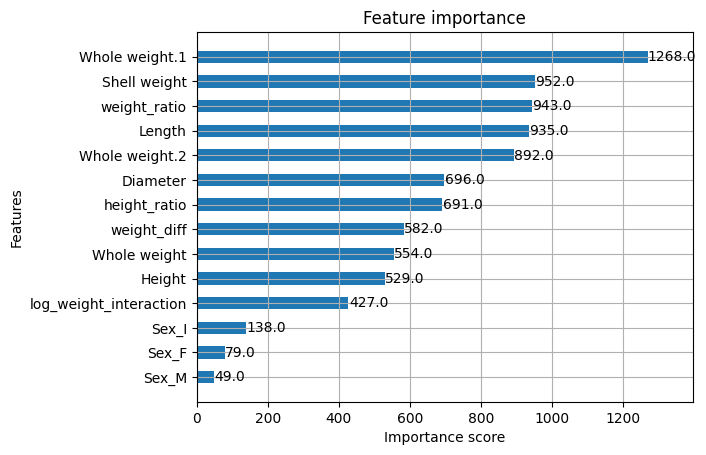

In [114]:
import xgboost as xgb
xgb.plot_importance(best_model, max_num_features=20, importance_type='weight', height=0.5)
plt.show()

In [132]:
test = pd.read_csv("test.csv")


In [127]:
test_fix = fix_data(test)

In [128]:
test_fix = feature_engineering(test_fix)

In [ ]:
X_new_np = test_fix.to_numpy().astype(np.float32)  # shape: (num_samples, num_features)

# Convert to PyTorch tensor
X_new_tensor = torch.tensor(X_new_np, dtype=torch.float32)

In [44]:
model.eval()
with torch.no_grad(): 
    y_pred = model(X_new_tensor)
    
y_pred_np = y_pred.numpy().flatten()

In [130]:
# Reorder test features to match training features
test_fix = test_fix[best_model.feature_names_in_]

# Now predict
y_pred = best_model.predict(test_fix)
y_pred = np.expm1(y_pred)  # if you used log1p on the target

In [133]:
submission = pd.DataFrame({'id': test['id'], 'Rings': y_pred})
submission.to_csv("my_submission.csv", index=False)